# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# dont show warnings
pd.options.mode.chained_assignment = None  # default='warn'

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
## Show top 5 values in feat_info
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
print('The sum of null-values in the dataframe before data wranling is: {}'.format(azdias.isnull().sum().sum()))

The sum of null-values in the dataframe before data wranling is: 4896838


In [6]:
def funktion(column):
    column = column.strip('[')
    column = column.strip(']')
    column = column.split(',')
    
    return(column)

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x:funktion(x))

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
## Create a dictionary so that we easy can map each variable against it
feat_info_dic = pd.Series(feat_info.missing_or_unknown.values,index=feat_info.attribute).to_dict()

In [9]:
feat_info_dic

{'AGER_TYP': ['-1', '0'],
 'ALTERSKATEGORIE_GROB': ['-1', '0', '9'],
 'ANREDE_KZ': ['-1', '0'],
 'CJT_GESAMTTYP': ['0'],
 'FINANZ_MINIMALIST': ['-1'],
 'FINANZ_SPARER': ['-1'],
 'FINANZ_VORSORGER': ['-1'],
 'FINANZ_ANLEGER': ['-1'],
 'FINANZ_UNAUFFAELLIGER': ['-1'],
 'FINANZ_HAUSBAUER': ['-1'],
 'FINANZTYP': ['-1'],
 'GEBURTSJAHR': ['0'],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': ['-1', '0'],
 'LP_LEBENSPHASE_FEIN': ['0'],
 'LP_LEBENSPHASE_GROB': ['0'],
 'LP_FAMILIE_FEIN': ['0'],
 'LP_FAMILIE_GROB': ['0'],
 'LP_STATUS_FEIN': ['0'],
 'LP_STATUS_GROB': ['0'],
 'NATIONALITAET_KZ': ['-1', '0'],
 'PRAEGENDE_JUGENDJAHRE': ['-1', '0'],
 'RETOURTYP_BK_S': ['0'],
 'SEMIO_SOZ': ['-1', '9'],
 'SEMIO_FAM': ['-1', '9'],
 'SEMIO_REL': ['-1', '9'],
 'SEMIO_MAT': ['-1', '9'],
 'SEMIO_VERT': ['-1', '9'],
 'SEMIO_LUST': ['-1', '9'],
 'SEMIO_ERL': ['-1', '9'],
 'SEMIO_KULT': ['-1', '9'],
 'SEMIO_RAT': ['-1', '9'],
 'SEMIO_KRIT': ['-1', '9'],
 'SEMIO_DOM': ['-1', '9'],
 'SEMIO_KA

In [10]:
## For-loop replacing every value if it is in list
for column in azdias:
    azdias[column] = np.where(azdias[column].isin(feat_info_dic[column]), np.nan, azdias[column])

In [11]:
## Count of null-values after operation
print('The sum of null-values in the dataframe after data wrangling is: {}'.format(azdias.isnull().sum().sum()))

The sum of null-values in the dataframe after data wrangling is: 8373929


In [12]:
## See how many null values there are in each column
pd.set_option('display.max_rows', 200)
azdias.info(verbose = True ,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
FINANZTYP                891221 non-null float64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMI

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Investigate patterns in the amount of missing data in each column.

## Show top 10 with most null-values
percent_missing = azdias.isnull().sum() * 100 / len(azdias)
missing_value_df = pd.DataFrame({'column_name': azdias.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values(by='percent_missing', ascending=False).head(10)

,column_name,percent_missing
TITEL_KZ,TITEL_KZ,99.757636
AGER_TYP,AGER_TYP,76.955435
KK_KUNDENTYP,KK_KUNDENTYP,65.596749
KBA05_BAUMAX,KBA05_BAUMAX,53.468668
GEBURTSJAHR,GEBURTSJAHR,44.020282
ALTER_HH,ALTER_HH,34.813699
KKK,KKK,17.735668
REGIOTYP,REGIOTYP,17.735668
W_KEIT_KIND_HH,W_KEIT_KIND_HH,16.605084
KBA05_ANTG1,KBA05_ANTG1,14.959701


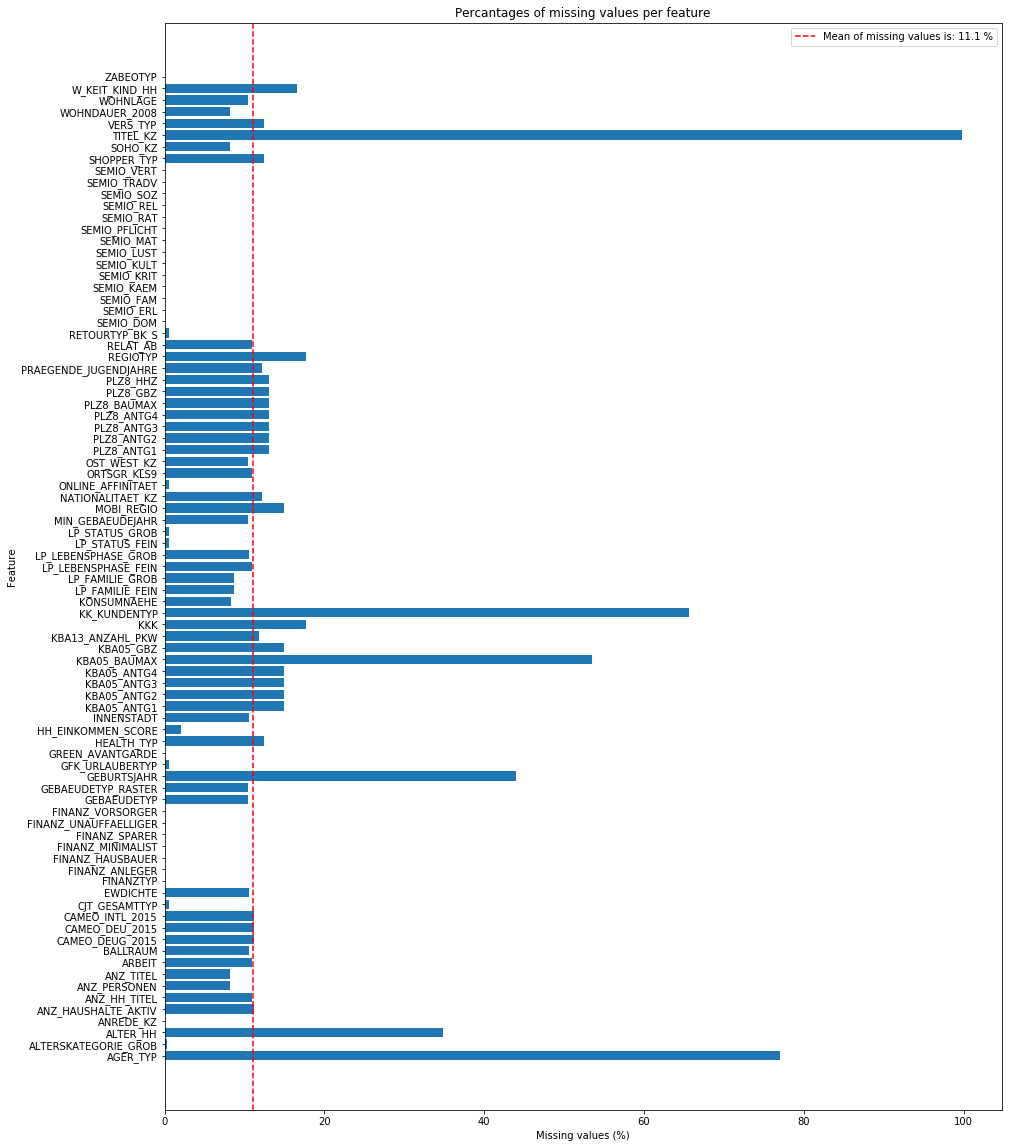

In [14]:
mean_missing_values = round(100 * (azdias.isnull().sum().sum() / azdias.size), 1)

plt.figure(figsize=(15,20))
plt.barh(missing_value_df['percent_missing'].index,
missing_value_df['percent_missing'].values, align='center')
plt.legend()

plt.ylabel('Feature')
plt.xlabel('Missing values (%)')
plt.title('Percantages of missing values per feature')
plt.axvline(x=mean_missing_values, color='red', ls = '--', label = 'Mean of missing values is: {mean} {character}'.format(mean = mean_missing_values, character = '%'))
plt.legend()

plt.show()

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

drop_columns = missing_value_df[missing_value_df['percent_missing'] > 30].index.tolist()

In [16]:
print('Columns that will be dropped due to missing values is: {}'.format(drop_columns))

Columns that will be dropped due to missing values is: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [17]:
azdias = azdias.drop(columns = drop_columns, axis = 1)

In [18]:
print('Columns that remains after operation is: {}'.format(len(azdias.columns)))

Columns that remains after operation is: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

The mean of missing data per column is about 11 percentages. I decided to drop the "outliers" containing more than 30 percent which was 6 variables.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

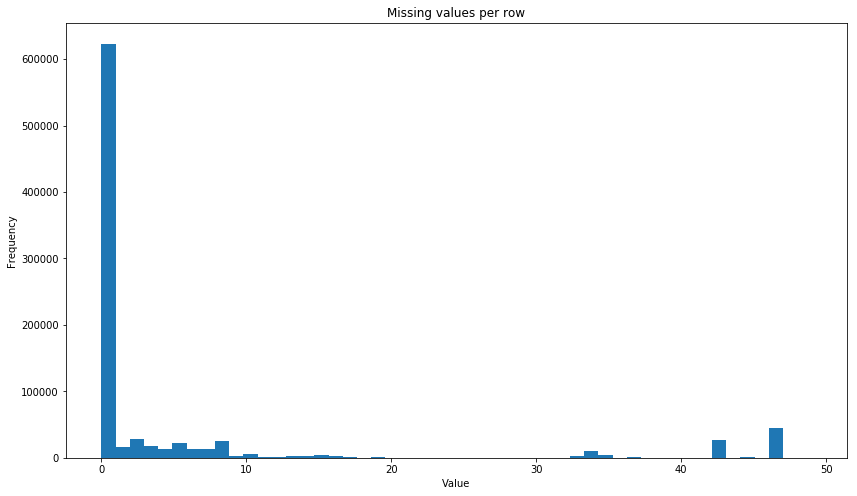

In [19]:
# How much data is missing in each row of the dataset?

null_per_row = azdias.isnull().sum(axis=1)

plt.figure(figsize=(14,8))
plt.hist(null_per_row, bins = 50)
plt.title('Missing values per row')
plt.ylabel('Frequency')
plt.xlabel('Value')

plt.show()

In [20]:
null_per_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_na_more_than_twenty = azdias[azdias.isnull().sum(axis=1) > 20]
azdias_na_less_equal_to_twenty = azdias[azdias.isnull().sum(axis=1) <= 20]

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


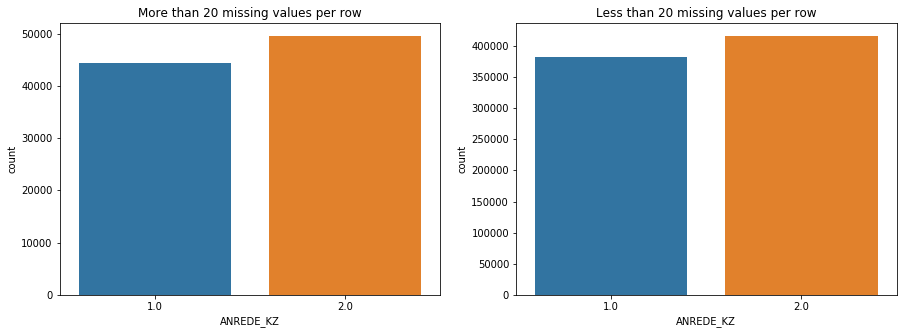

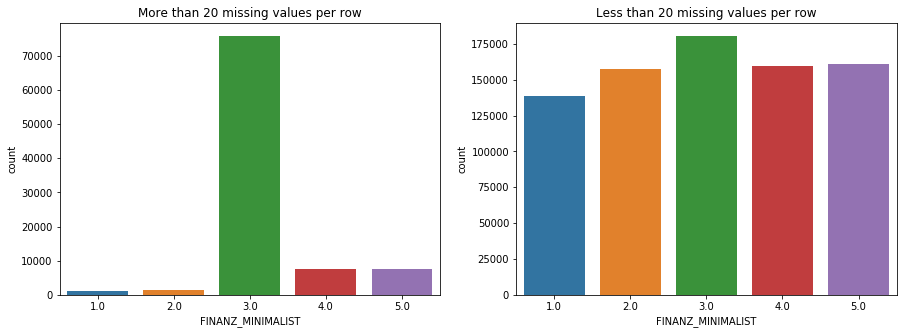

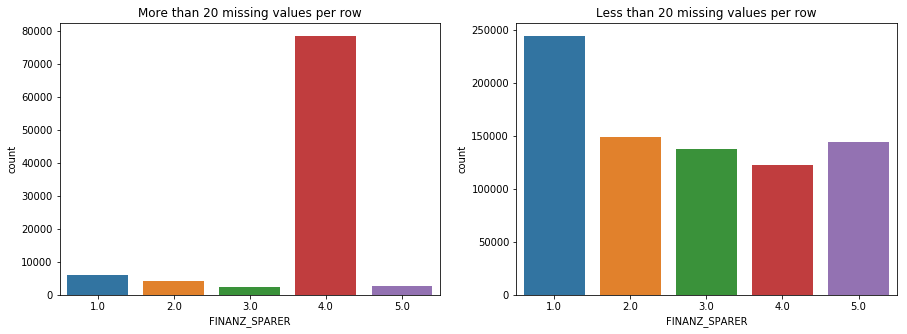

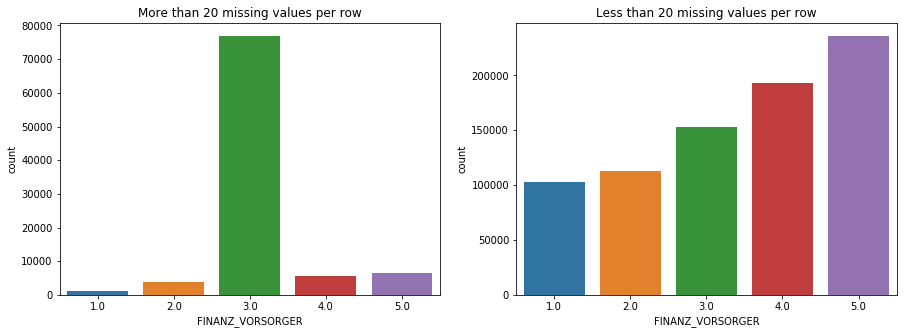

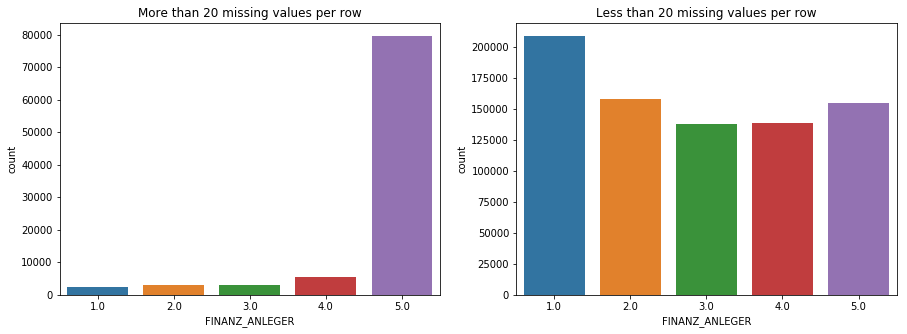

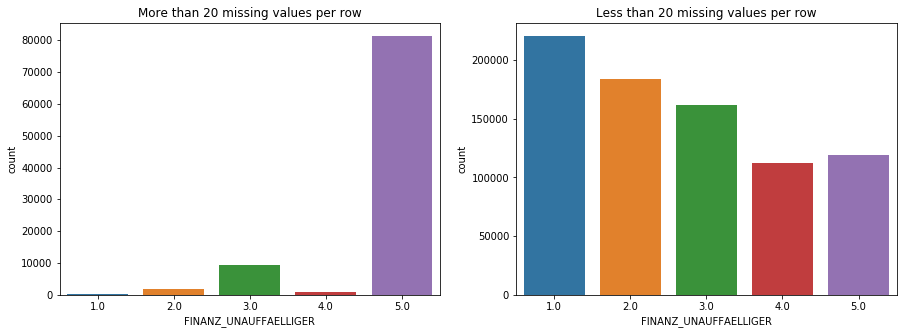

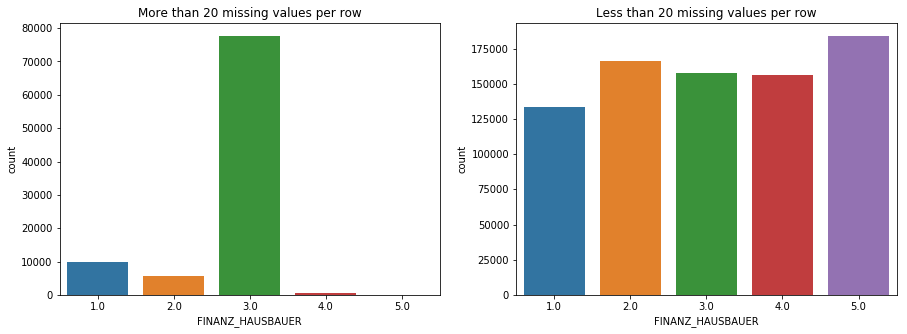

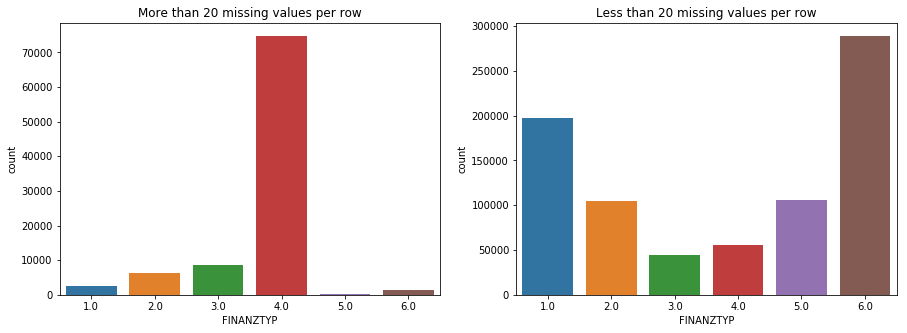

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

compare = missing_value_df[missing_value_df['percent_missing'] == 0][:8].index.tolist()

for columns in compare: 
    
    max_value1 = max(azdias_na_more_than_twenty[columns].value_counts())
    max_value2 = max(azdias_na_less_equal_to_twenty[columns].value_counts())
    max_value3 = max(max_value1,max_value2)

    fig, ax = plt.subplots(1,2, figsize = (15, 5))

    sns.countplot(azdias_na_more_than_twenty[columns], ax=ax[0]).set(title='More than 20 missing values per row')
#     ax[0].set_ylim(bottom=0, top=max_value3 + 10000)
    sns.countplot(azdias_na_less_equal_to_twenty[columns], ax=ax[1]).set(title='Less than 20 missing values per row')
#     ax[1].set_ylim(bottom=0, top=max_value3 + 10000)
    fig.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

I decided to split the data where rows has more than 20 missing values. Mean seems to be about 5,6 and looking in the graph above, 20 seems like a good limit. 

What I can tell from the distribution of both groups is that they seem to differ quite much looking at the variables "FINANZ_%". When looking at the first variable ANDREDE_KZ (gender), they seem to have about the same distribution. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?

## Update the list (we dropped some variables in the beggining)
feat_info = feat_info[feat_info.attribute.isin(azdias_na_less_equal_to_twenty.columns.tolist())]

print('The datatypes and number of features in them are {}'.format(feat_info.groupby('type').count()['attribute'].to_dict()))

The datatypes and number of features in them are {'categorical': 18, 'mixed': 6, 'numeric': 6, 'ordinal': 49}


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorial_features = feat_info[feat_info['type'] == 'categorical']['attribute'].values.tolist()

In [25]:
binary_variables = []
multi_variables = []

for features in categorial_features:
    if azdias_na_less_equal_to_twenty[features].nunique() == 2:
        binary_variables.append(features)
    else:
        multi_variables.append(features)
        
print('Features containing two values are: {}'.format(binary_variables))
print('Features containing more than two values are: {}'.format(multi_variables))

Features containing two values are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Features containing more than two values are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [26]:
for features in binary_variables:
    print('Values in feature {a} are: {b}'.format(a=features, b=azdias_na_less_equal_to_twenty[features].unique()))

Values in feature ANREDE_KZ are: [ 2.  1.]
Values in feature GREEN_AVANTGARDE are: [ 0.  1.]
Values in feature SOHO_KZ are: [ 1.  0.]
Values in feature VERS_TYP are: [  2.   1.  nan]
Values in feature OST_WEST_KZ are: ['W' 'O']


In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_na_less_equal_to_twenty['OST_WEST_KZ'].replace({'W': 1, 'O': 2}, inplace=True)

In [28]:
for features in multi_variables:
    print('Values in feature {a} are: {b}'.format(a=features, b=azdias_na_less_equal_to_twenty[features].unique()))

Values in feature CJT_GESAMTTYP are: [  5.   3.   2.   4.   1.   6.  nan]
Values in feature FINANZTYP are: [ 1.  6.  5.  2.  4.  3.]
Values in feature GFK_URLAUBERTYP are: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Values in feature LP_FAMILIE_FEIN are: [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
Values in feature LP_FAMILIE_GROB are: [  3.   1.  nan   5.   2.   4.]
Values in feature LP_STATUS_FEIN are: [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
Values in feature LP_STATUS_GROB are: [  1.   2.   4.   5.   3.  nan]
Values in feature NATIONALITAET_KZ are: [  1.   3.   2.  nan]
Values in feature SHOPPER_TYP are: [  3.   2.   1.   0.  nan]
Values in feature ZABEOTYP are: [ 5.  3.  4.  1.  6.  2.]
Values in feature GEBAEUDETYP are: [ 8.  1.  3.  2.  6.  4.  5.]
Values in feature CAMEO_DEUG_2015 are: ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
Values in feature CAMEO_DEU_2015 are: ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8

In [29]:
# Dropping the multilevel categorical columns

print('Columns that will be dropped are: {}'.format(multi_variables))
print('')

print('Number of columns in dataframe before dropping multi-variables are: {}'.format(len(azdias_na_less_equal_to_twenty.columns)))

azdias_na_less_equal_to_twenty.drop(multi_variables, axis=1, inplace=True)

print('Number of columns in dataframe after dropping multi-variables are: {}'.format(len(azdias_na_less_equal_to_twenty.columns)))

Columns that will be dropped are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Number of columns in dataframe before dropping multi-variables are: 79
Number of columns in dataframe after dropping multi-variables are: 66


In [30]:
## I see that i have some variables containing null-values, I will decide to drop them so that i can continue with clean data

print('Number of rows in dataframe before dropping null values are: {}'.format(len(azdias_na_less_equal_to_twenty)))

azdias_na_less_equal_to_twenty.dropna(axis=0, inplace=True)

print('Number of rows in dataframe after dropping null values are: {}'.format(len(azdias_na_less_equal_to_twenty)))

Number of rows in dataframe before dropping null values are: 797426
Number of rows in dataframe after dropping null values are: 623209


In [31]:
azdias_na_less_equal_to_twenty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
PRAEGENDE_JUGENDJAHRE    623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null float64
SEMIO_FAM                623209 non-null float64
SEMIO_REL                623209 non-null float64
SEMIO_MAT                623209 non-null float64
SEMIO_V

#### Discussion 1.2.1: Re-Encode Categorical Features

I dedicided to drop the variables with multi-values and the rows containg null-values. I do not think this is the perfect way but because of some lack of time finishing this project, I decided to do so. If i had the time, I would like to impute values for these variables. I think that we already dropped the outliers that was needed in the beginning of this project. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute'].values.tolist()

In [33]:
for feature in mixed_features:
    print(feature)

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
PLZ8_BAUMAX


In [34]:
azdias_na_less_equal_to_twenty['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    144627
8.0     114745
5.0      69527
10.0     68820
3.0      44103
15.0     33585
9.0      29033
11.0     28375
6.0      22802
12.0     19933
4.0      18371
1.0      15233
2.0       6189
13.0      4450
7.0       3416
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def generation(x):
    
    if x < 3:
        return 1
    elif x < 5:
        return 2
    elif x < 8:
        return 3
    elif x < 10:
        return 4
    elif x < 14:
        return 5
    else:
        return 6
    
azdias_na_less_equal_to_twenty['GENERATION_DECADE'] = azdias_na_less_equal_to_twenty['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: generation(x))

In [36]:
azdias_na_less_equal_to_twenty['GENERATION_DECADE'].value_counts()

6    178212
4    143778
5    121578
3     95745
2     62474
1     21422
Name: GENERATION_DECADE, dtype: int64

In [37]:
## Creating a dummy-variable, 1 indicates "Mainstream", 0 indicates "Advantage"
azdias_na_less_equal_to_twenty['MOVEMENT'] = np.where(azdias_na_less_equal_to_twenty.PRAEGENDE_JUGENDJAHRE.isin([1,3,5,8,10,12,14]), 1, 0)

In [38]:
azdias_na_less_equal_to_twenty['MOVEMENT'].value_counts()

1    476988
0    146221
Name: MOVEMENT, dtype: int64

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_na_less_equal_to_twenty['CAMEO_INTL_2015'].head(10)

1     51
2     24
4     43
5     54
6     22
7     14
8     13
9     15
10    51
19    34
Name: CAMEO_INTL_2015, dtype: object

In [40]:
## for-loop to go through each element 
first_index = []
second_index = []

for num in azdias_na_less_equal_to_twenty['CAMEO_INTL_2015']:
    first_index.append(num[0])
    second_index.append(num[1])
    
azdias_na_less_equal_to_twenty['WEALTH'] = first_index
azdias_na_less_equal_to_twenty['LIFE_STAGE'] = second_index

In [41]:
## Change datatype to integer for the new variables
azdias_na_less_equal_to_twenty['WEALTH'] = azdias_na_less_equal_to_twenty['WEALTH'].astype('int64')
azdias_na_less_equal_to_twenty['LIFE_STAGE'] = azdias_na_less_equal_to_twenty['LIFE_STAGE'].astype('int64')

In [42]:
azdias_na_less_equal_to_twenty[['CAMEO_INTL_2015','WEALTH', 'LIFE_STAGE']].head(10)

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51,5,1
2,24,2,4
4,43,4,3
5,54,5,4
6,22,2,2
7,14,1,4
8,13,1,3
9,15,1,5
10,51,5,1
19,34,3,4


#### Discussion 1.2.2: Engineer Mixed-Type Features

I had a look at the two variables called PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. I saw in the description that they held two different values and decided to split them up to gather more information. I did this by doing some simple feature_enginering and dropped the two original variables because they are not needed anymore. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
## Drop the features we have done feature engineering on

print('Number of columns in dataframe before dropping null values are: {}'.format(len(azdias_na_less_equal_to_twenty.columns)))

azdias_na_less_equal_to_twenty.drop(columns = ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)

print('Number of columns in dataframe after dropping null values are: {}'.format(len(azdias_na_less_equal_to_twenty.columns)))

Number of columns in dataframe before dropping null values are: 70
Number of columns in dataframe after dropping null values are: 68


In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# It seems to be only numerical features now
np.unique(azdias_na_less_equal_to_twenty.dtypes.values)

array([dtype('int64'), dtype('float64')], dtype=object)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [46]:
## You need to restart the kernal and import the data, then start here and it will work

def funktion(column):
    column = column.strip('[')
    column = column.strip(']')
    column = column.split(',')
    
    return(column)

In [47]:
def generation(x):
    
    if x < 3:
        return 1
    elif x < 5:
        return 2
    elif x < 8:
        return 3
    elif x < 10:
        return 4
    elif x < 14:
        return 5
    else:
        return 6

In [48]:
def clean_data(df):
    
    ## Part 1: Create a dictonary replacing values

    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x:funktion(x))
    
    feat_info_dic = pd.Series(feat_info.missing_or_unknown.values,index=feat_info.attribute).to_dict()

    for column in df:
        df[column] = np.where(df[column].isin(feat_info_dic[column]), np.nan, df[column])
    
    ## Part 2: Remove variables with more that 30 % null-values
    
    percent_missing = df.isnull().sum() * 100 / len(df)
    
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

    drop_columns = missing_value_df[missing_value_df['percent_missing'] > 30].index.tolist()

    df = df.drop(columns = drop_columns, axis = 1) 
    
    azdias_na_less_equal_to_twenty = df[df.isnull().sum(axis=1) <= 20]
    
    feat_info_2 = feat_info[feat_info.attribute.isin(df.columns.tolist())]
    
    ## Part 3: Split inte categorical features and drop multi-variables
    
    categorial_features = feat_info_2[feat_info_2['type'] == 'categorical']['attribute'].values.tolist()

    binary_variables = []
    multi_variables = []
    
    for features in categorial_features:
        if azdias_na_less_equal_to_twenty[features].nunique() == 2:
            binary_variables.append(features)
        else:
            multi_variables.append(features)

    azdias_na_less_equal_to_twenty['OST_WEST_KZ'].replace({'W': 1, 'O': 2}, inplace=True)
    
    ## Part 4: Drop multi-variables and na-rows
    
    azdias_na_less_equal_to_twenty.drop(multi_variables, axis=1, inplace=True)
    
    azdias_na_less_equal_to_twenty.dropna(axis=0, inplace=True)
    
    ## Part 5: Feature Engineering 

    azdias_na_less_equal_to_twenty['GENERATION_DECADE'] = azdias_na_less_equal_to_twenty['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: generation(x))
    
    azdias_na_less_equal_to_twenty['MOVEMENT'] = np.where(azdias_na_less_equal_to_twenty.PRAEGENDE_JUGENDJAHRE.isin([1,3,5,8,10,12,14]), 1, 0)
    
    first_index = []
    second_index = []

    for num in azdias_na_less_equal_to_twenty['CAMEO_INTL_2015']:
        first_index.append(num[0])
        second_index.append(num[1])
    
    azdias_na_less_equal_to_twenty['WEALTH'] = first_index
    azdias_na_less_equal_to_twenty['LIFE_STAGE'] = second_index
    
    azdias_na_less_equal_to_twenty['WEALTH'] = azdias_na_less_equal_to_twenty['WEALTH'].astype('int64')
    azdias_na_less_equal_to_twenty['LIFE_STAGE'] = azdias_na_less_equal_to_twenty['LIFE_STAGE'].astype('int64')
    
    ## Part 6: Drop columns
    azdias_na_less_equal_to_twenty.drop(columns = ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)
    
    ## Part 7: Return Dataframe  
    return azdias_na_less_equal_to_twenty.reset_index(drop=True)

In [49]:
azdias_clean = clean_data(azdias)
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623209 entries, 0 to 623208
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null float64
SEMIO_FAM                623209 non-null float64
SEMIO_REL                623209 non-null float64
SEMIO_MAT                623209 non-null float64
SEMIO_VERT               623209 non-null float64
SEMIO_L

In [50]:
azdias_clean.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6,1,5,1
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6,0,2,4
2,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4,1,4,3
3,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2,1,5,4
4,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,5,1,2,2


In [51]:
np.unique(azdias_clean.dtypes.values)

array([dtype('int64'), dtype('float64')], dtype=object)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [52]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


In [53]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_clean)
azdias_scaled = pd.DataFrame(azdias_scaled, columns = azdias_clean.columns.tolist())
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,-0.667337,1.441599,0.583438,-0.201181,-0.171845,0.656462,1.164454,0.553670,1.147882,-1.251108
1,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.667337,0.400949,0.583438,-0.201181,-0.171845,-0.823844,1.164454,-1.806129,-0.909997,0.749822
2,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,0.009742,-0.639702,-0.314764,0.809743,0.263748,1.396614,-0.213400,0.553670,0.461922,0.082845
3,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,-0.667337,1.441599,1.481640,-1.212105,-1.043032,-0.083691,-1.591253,0.553670,1.147882,0.749822
4,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,-0.667337,1.441599,1.481640,0.809743,0.263748,-0.083691,0.475527,0.553670,-0.909997,-0.584131


### Discussion 2.1: Apply Feature Scaling

I have cleaned my data as mentioned before (dropped NA-values) and then I used the Standard Scaler to scale my data. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [54]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

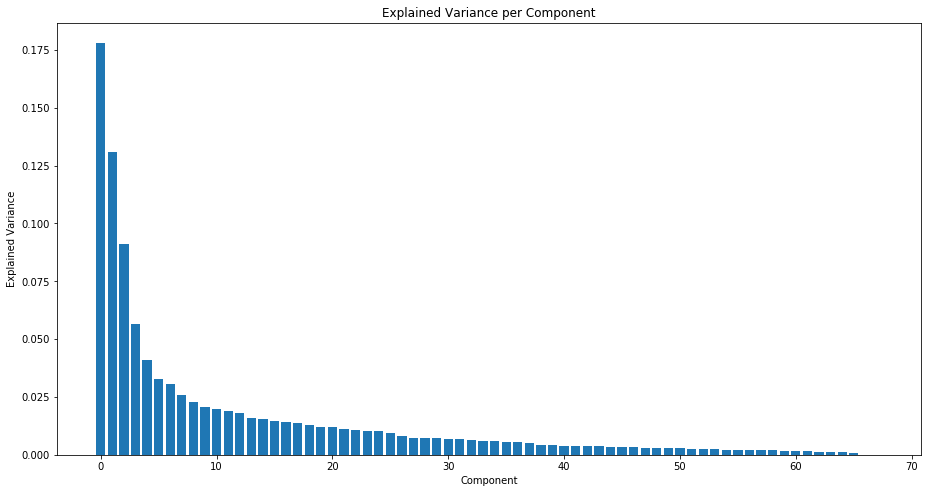

In [55]:
# Investigate the variance accounted for by each principal component.
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
langs = range(len(pca.explained_variance_ratio_))
students = pca.explained_variance_ratio_
ax.bar(langs,students)
plt.title('Explained Variance per Component')
plt.ylabel('Explained Variance')
plt.xlabel('Component')

plt.show()

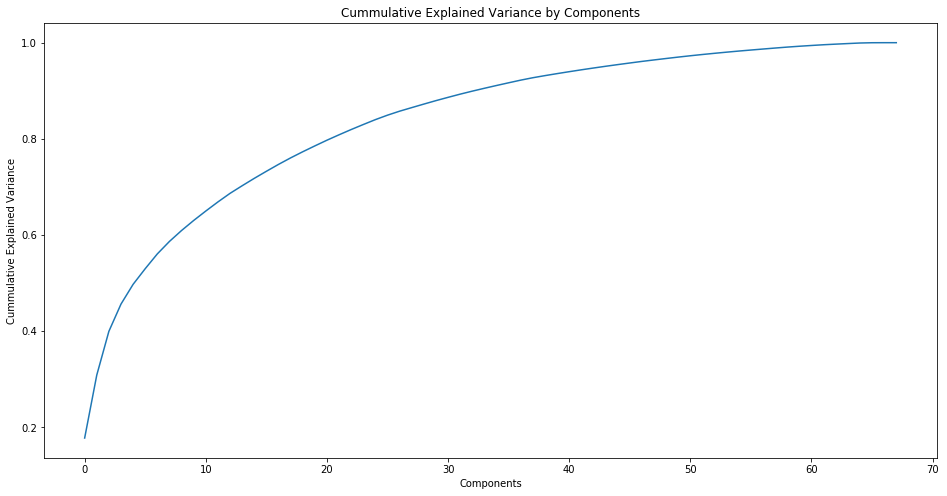

In [56]:
plt.figure(figsize=(16,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cummulative Explained Variance by Components')
plt.ylabel('Cummulative Explained Variance')
plt.xlabel('Components')
plt.show()

In [57]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_27 = PCA(n_components=27) # 27 motsvarar 85 % av datat
azdias_scaled_pca = pca_27.fit_transform(azdias_scaled)
print('Number of components after PCA is: {}'.format(pca_27.n_components_))

Number of components after PCA is: 27


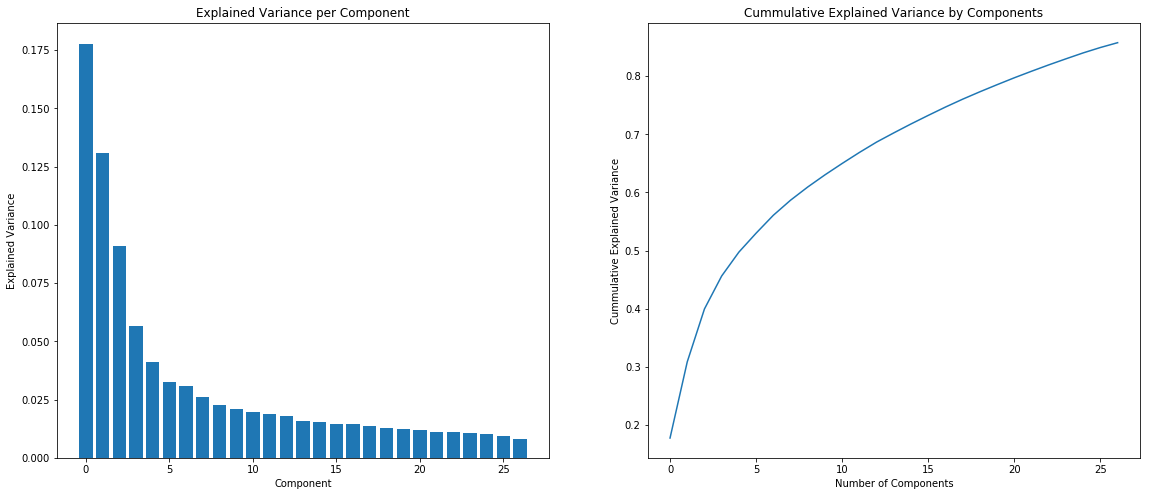

In [58]:
components = range(len(pca_27.explained_variance_ratio_))
values = pca_27.explained_variance_ratio_

plt.figure(figsize=(30, 8))

plt.subplot(131)
plt.bar(components, values)
plt.title('Explained Variance per Component')
plt.ylabel('Explained Variance')
plt.xlabel('Component')
plt.subplot(132)
plt.plot(np.cumsum(pca_27.explained_variance_ratio_))
plt.title('Cummulative Explained Variance by Components')
plt.ylabel('Cummulative Explained Variance')
plt.xlabel('Number of Components')
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

I decided to use tha components that corresponds to 85 % of the variation, that number was equal to 27. I think this is a good way, dropping more that 50 % of the components but only loosing 15 % of the variation.  

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [59]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

import operator

def weights_features(pca, i):
    
    values = []
    columns = []

    for count, value in enumerate(azdias_scaled.columns):
        
        values.append(pca.components_[i][count])
        columns.append(value)
        
    feat_info_dic = pd.Series(values,index=columns).to_dict()
    return sorted(feat_info_dic.items(), key = operator.itemgetter(1), reverse = True)      

In [60]:
weights_features(pca, 1)

[('ALTERSKATEGORIE_GROB', 0.2628189455967174),
 ('SEMIO_ERL', 0.2334076921044249),
 ('FINANZ_VORSORGER', 0.230180614442511),
 ('SEMIO_LUST', 0.18211075863030277),
 ('RETOURTYP_BK_S', 0.16491363443681825),
 ('W_KEIT_KIND_HH', 0.1192954017574703),
 ('SEMIO_KRIT', 0.11926874219609426),
 ('FINANZ_HAUSBAUER', 0.1067996062886114),
 ('SEMIO_KAEM', 0.10617390416502617),
 ('PLZ8_ANTG3', 0.08634930464026584),
 ('ANREDE_KZ', 0.08536950865555704),
 ('EWDICHTE', 0.08507170782935805),
 ('ORTSGR_KLS9', 0.0849045363321791),
 ('PLZ8_ANTG4', 0.08275237898801753),
 ('PLZ8_BAUMAX', 0.07785182244029132),
 ('FINANZ_MINIMALIST', 0.0739994524415935),
 ('SEMIO_DOM', 0.06529239292951024),
 ('ARBEIT', 0.062358196022683464),
 ('WEALTH', 0.06119661135882156),
 ('WOHNDAUER_2008', 0.060308364560773625),
 ('KBA05_ANTG4', 0.059860962717013876),
 ('RELAT_AB', 0.058827713902967975),
 ('PLZ8_ANTG2', 0.05711007783839985),
 ('ANZ_HAUSHALTE_AKTIV', 0.052888238047898516),
 ('KBA05_ANTG3', 0.041210463233962796),
 ('HH_EINKOMM

In [61]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_features(pca, 2)

[('SEMIO_VERT', 0.34914303199657437),
 ('SEMIO_SOZ', 0.26390953571893266),
 ('SEMIO_FAM', 0.25176087804527525),
 ('SEMIO_KULT', 0.2326384185819632),
 ('FINANZ_MINIMALIST', 0.1614262681005797),
 ('RETOURTYP_BK_S', 0.1132181829714431),
 ('FINANZ_VORSORGER', 0.09641509607589738),
 ('W_KEIT_KIND_HH', 0.08941852636003941),
 ('ALTERSKATEGORIE_GROB', 0.08025321224060099),
 ('SEMIO_REL', 0.07809769266674399),
 ('SEMIO_LUST', 0.07232624545724738),
 ('GREEN_AVANTGARDE', 0.05866143267337512),
 ('SEMIO_MAT', 0.04930680265517975),
 ('ORTSGR_KLS9', 0.04673703196450482),
 ('EWDICHTE', 0.04665551310093429),
 ('PLZ8_BAUMAX', 0.04412914372610781),
 ('PLZ8_ANTG4', 0.04244652272823161),
 ('PLZ8_ANTG3', 0.04126942660891065),
 ('WOHNDAUER_2008', 0.035882917361777684),
 ('ARBEIT', 0.02969427157158183),
 ('RELAT_AB', 0.028483926620205234),
 ('PLZ8_ANTG2', 0.027143206358064362),
 ('KBA05_ANTG4', 0.024582881918867133),
 ('ANZ_HAUSHALTE_AKTIV', 0.022246481167654247),
 ('VERS_TYP', 0.01996120599927049),
 ('WEALTH

In [62]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_features(pca, 3)

[('GREEN_AVANTGARDE', 0.3444856740997765),
 ('EWDICHTE', 0.2488646371439816),
 ('ORTSGR_KLS9', 0.24722990364166128),
 ('LP_LEBENSPHASE_FEIN', 0.20857707017927668),
 ('LP_LEBENSPHASE_GROB', 0.20485300701411766),
 ('ANZ_PERSONEN', 0.18941343037930639),
 ('ONLINE_AFFINITAET', 0.16942546510472967),
 ('SEMIO_DOM', 0.11833570291850973),
 ('RELAT_AB', 0.10482343194451249),
 ('PLZ8_ANTG3', 0.10195013036353016),
 ('PLZ8_ANTG2', 0.09357262446963717),
 ('PLZ8_ANTG4', 0.09058850199348335),
 ('SEMIO_KAEM', 0.08867748366308911),
 ('PLZ8_HHZ', 0.08653360536376341),
 ('PLZ8_BAUMAX', 0.07837178459512881),
 ('KBA05_ANTG1', 0.07584672268656101),
 ('ARBEIT', 0.07578099076931083),
 ('FINANZ_UNAUFFAELLIGER', 0.07248586194992768),
 ('FINANZ_MINIMALIST', 0.056522599806960755),
 ('SEMIO_TRADV', 0.05480259600951678),
 ('SEMIO_RAT', 0.05273593261678304),
 ('LIFE_STAGE', 0.05145166135870211),
 ('ANREDE_KZ', 0.04659428290134571),
 ('GENERATION_DECADE', 0.04555663308243206),
 ('ANZ_TITEL', 0.04503048167696694),
 ('

### Discussion 2.3: Interpret Principal Components

I will only try do explain the first principal component.

From the first principal component we can see that it is positively correlated with these top 3 variables:
- 'ALTERSKATEGORIE_GROB', 0.2628189455967174 (ESTIMATED AGE, HIGHER VALUE = OLDER)
- 'SEMIO_ERL', 0.2334076921044249 (EVENT-ORIENTED, lower number, highest affinity)
- 'FINANZ_VORSORGER', 0.230180614442511 (be prepared, lower number = higher)

This means that these 3 vary togehter. If one increases then the other two also seem to increase. 

From the first principal component we can see that it is negativily correlated with these top 3 variables: 
- 'SEMIO_PFLICHT',-0.2412962184903324 (dutiful, lower number, highest affinity)
- 'GENERATION_DECADE', -0.25179869556515605 (higher number, later decade)
- 'SEMIO_REL', -0.2653563439165148 (religious, lower number, highest affinity)

This means that these 3 vary togehter. If one decreases then the other two also seem to decrease. 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [63]:
# Over a number of different cluster counts...

# run k-means clustering on the data and...
    
# compute the average within-cluster distances.
    
from sklearn.cluster import KMeans
    
distortions = []
K = range(1,17,2)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(azdias_scaled_pca)
    distortions.append(kmeanModel.inertia_)

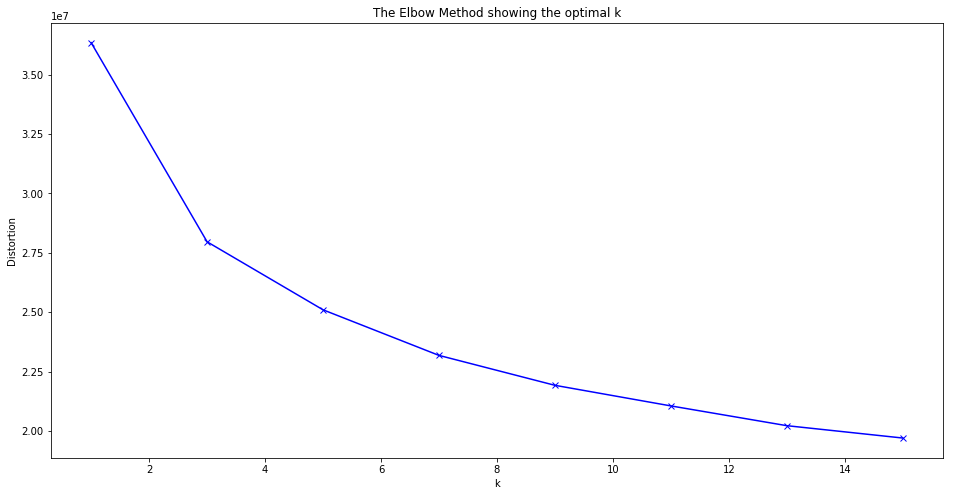

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 13)
model_clusters13 = kmeans.fit(azdias_scaled_pca)
azdias_predictions_clusters13 = model_clusters13.predict(azdias_scaled_pca)

### Discussion 3.1: Apply Clustering to General Population

I have used the elbow-method to decide the size of clusters, and I think that 13 seems to be correct. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [66]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [67]:
# Apply cleaning function on our new data
customers_clean = clean_data(customers)

customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121111 entries, 0 to 121110
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     121111 non-null float64
ANREDE_KZ                121111 non-null float64
FINANZ_MINIMALIST        121111 non-null float64
FINANZ_SPARER            121111 non-null float64
FINANZ_VORSORGER         121111 non-null float64
FINANZ_ANLEGER           121111 non-null float64
FINANZ_UNAUFFAELLIGER    121111 non-null float64
FINANZ_HAUSBAUER         121111 non-null float64
GREEN_AVANTGARDE         121111 non-null float64
HEALTH_TYP               121111 non-null float64
LP_LEBENSPHASE_FEIN      121111 non-null float64
LP_LEBENSPHASE_GROB      121111 non-null float64
RETOURTYP_BK_S           121111 non-null float64
SEMIO_SOZ                121111 non-null float64
SEMIO_FAM                121111 non-null float64
SEMIO_REL                121111 non-null float64
SEMIO_MAT                121111 non-null float64
SEMIO_VERT               121111 non-null float64
SEMIO_L

In [68]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,1.0,5.0,5.0,1.0,2.0,1.0,2,0,1,3
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,3.0,3.0,2.0,3.0,5.0,3.0,2,0,3,4
2,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,2.0,3.0,3.0,3.0,5.0,1.0,4,1,4,1
3,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2,0,3,4
4,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,1.0,5.0,5.0,2.0,3.0,2.0,2,0,2,3


In [69]:
## I had some differences in columns between the two datasets

def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d

customers_clean = fix_columns(customers_clean, azdias_clean.columns.tolist())

{'REGIOTYP', 'KKK'}


In [77]:
# Printing Number of columns
print('Number of columns in dataframe is now:', customers_clean.shape[1])

Number of columns in dataframe is now: 68


In [78]:
# Apply feature scaling to the general population demographics data. (KKK and REGIOTYP does not exist)
customers_scaled = scaler.transform(customers_clean)
customers_scaled = pd.DataFrame(customers_scaled, columns = customers_clean.columns.tolist())
customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION_DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.176307,-1.022678,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.856545,1.806129,-1.591638,...,-0.667337,1.441599,1.481640,-2.223028,-1.478625,-1.563996,-1.591253,-1.806129,-1.595957,0.082845
1,1.176307,0.977825,1.427283,-1.141401,1.114984,-1.221857,1.047073,0.608140,1.806129,-0.273496,...,0.686822,-0.639702,-1.212966,-0.201181,-0.171845,-0.083691,-1.591253,-1.806129,-0.224038,0.749822
2,0.202107,-1.022678,-0.042471,-1.141401,0.394976,0.848830,1.775773,-0.856545,-0.553670,1.044647,...,0.009742,-0.639702,-0.314764,-0.201181,-0.171845,-1.563996,-0.213400,0.553670,0.461922,-1.251108
3,0.202107,-1.022678,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.124203,1.806129,1.044647,...,-0.667337,1.441599,1.481640,-0.201181,0.699342,1.396614,-1.591253,-1.806129,-0.224038,0.749822
4,1.176307,-1.022678,1.427283,-1.141401,1.114984,-1.221857,-1.139028,-0.856545,1.806129,-0.273496,...,-0.667337,1.441599,1.481640,-1.212105,-1.043032,-0.823844,-1.591253,-1.806129,-0.909997,0.082845


In [79]:
# Apply PCA to our data
customers_scaled_pca = pca_27.transform(customers_scaled)
print('Number of components after PCA is: {}'.format(pca_27.n_components_))

Number of components after PCA is: 27


In [80]:
# Predict with our model
customers_predictions_clusters13 = model_clusters13.predict(customers_scaled_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


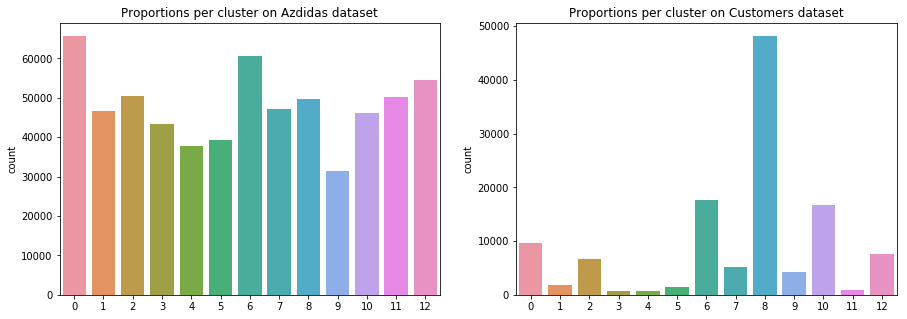

In [81]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
    
fig, ax = plt.subplots(1,2, figsize = (15, 5))
    
sns.countplot(azdias_predictions_clusters13, ax=ax[0]).set(title='Proportions per cluster on Azdidas dataset')
sns.countplot(customers_predictions_clusters13, ax=ax[1]).set(title='Proportions per cluster on Customers dataset')

fig.show()

In [91]:
def difference(dataframe1, dataframe2):

    unique1, counts1 = np.unique(dataframe1, return_counts=True)
    rows1 = len(dataframe1)
    test1 = (counts1/rows1).tolist()
    unique2, counts2 = np.unique(dataframe2, return_counts=True)
    rows2 = len(dataframe2)
    test2 = (counts2/rows2).tolist()
    
    lists = [test1, test2]
    df = pd.concat([pd.Series(x) for x in lists], axis=1).rename(columns={0:'Customers_Dataset', 1:'Azdias_Dataset'})
    
    return df

In [92]:
difference_table = difference(customers_predictions_clusters13, azdias_predictions_clusters13)

In [93]:
difference_table

,Customers_Dataset,Azdias_Dataset
0,0.079927,0.105451
1,0.014697,0.075020
2,0.055668,0.080808
3,0.005648,0.069556
4,0.005086,0.060708
5,0.011906,0.063163
6,0.145965,0.097295
7,0.042630,0.075522
8,0.397734,0.079964
9,0.034547,0.050532


In [96]:
## Create some more columns so we can see the biggest differences
difference_table['Difference'] = difference_table['Customers_Dataset'] - difference_table['Azdias_Dataset']
difference_table['DifferenceABS'] = abs(difference_table['Difference'])

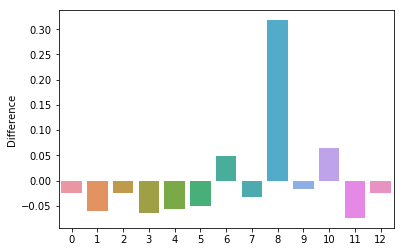

In [103]:
sns.barplot(x=difference_table.index, y="Difference", data=difference_table)

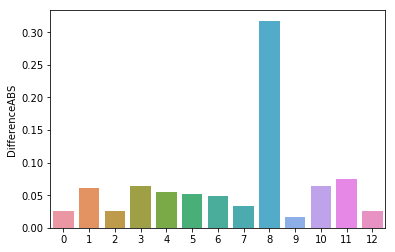

In [104]:
sns.barplot(x=difference_table.index, y="DifferenceABS", data=difference_table)

In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.



In [105]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_0 = scaler.inverse_transform(pca_27.inverse_transform(model_clusters13.cluster_centers_[8]))

overrepresented = pd.Series(data = centroid_0, index = customers_clean.columns)

In [106]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_1 = scaler.inverse_transform(pca_27.inverse_transform(model_clusters13.cluster_centers_[11]))

underrepresented = pd.Series(data = centroid_1, index = customers_clean.columns)

In [107]:
test3 = pd.concat([overrepresented,underrepresented],axis=1).rename(columns={0:'OVERREPRESENTED', 1:'UNDERREPRESENTED'})

In [115]:
test3['FACTOR'] = (test3['OVERREPRESENTED'] / test3['UNDERREPRESENTED']) * 100

In [120]:
test3['DIST_FROM_100'] = abs(100 - test3['FACTOR'])

In [124]:
test3.sort_values(by = 'DIST_FROM_100', ascending = False)

,OVERREPRESENTED,UNDERREPRESENTED,FACTOR,DIST_FROM_100
ANZ_TITEL,0.013578,0.001170,1160.370855,1060.370855
KBA05_ANTG1,2.752283,0.364649,754.776738,654.776738
GREEN_AVANTGARDE,0.959250,0.131282,730.679835,630.679835
LP_LEBENSPHASE_FEIN,25.207458,8.833711,285.355243,185.355243
FINANZ_MINIMALIST,4.843032,1.874954,258.301324,158.301324
LP_LEBENSPHASE_GROB,7.335058,2.975731,246.496006,146.496006
MOBI_REGIO,4.152308,1.747534,237.609579,137.609579
SEMIO_ERL,4.153859,2.018381,205.801502,105.801502
FINANZ_VORSORGER,4.209135,2.082049,202.163070,102.163070
PLZ8_ANTG1,2.800250,1.391190,201.284521,101.284521


### Discussion 3.3: Compare Customer Data to Demographics Data

Some variables that I found interresting to dig in to is: 

We can see that in the overrepresented cluster 

KBA05_ANTG1
LP_LEBENSPHASE_FEIN
FINANZ_MINIMALIST
LP_LEBENSPHASE_GROB
MOBI_REGIO
SEMIO_ERL
FINANZ_VORSORGER
PLZ8_ANTG1
SEMIO_LUST
ANZ_HAUSHALTE_AKTIV
FINANZ_SPARER
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_UNAUFFAELLIGER



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.